In [2]:
words = open('names.txt', 'r').read().splitlines()

In [12]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1 


In [23]:
import torch


In [148]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [149]:
N = torch.zeros((27,27), dtype= torch.int32)

In [150]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2]  += 1
        


(-0.5, 26.5, 26.5, -0.5)

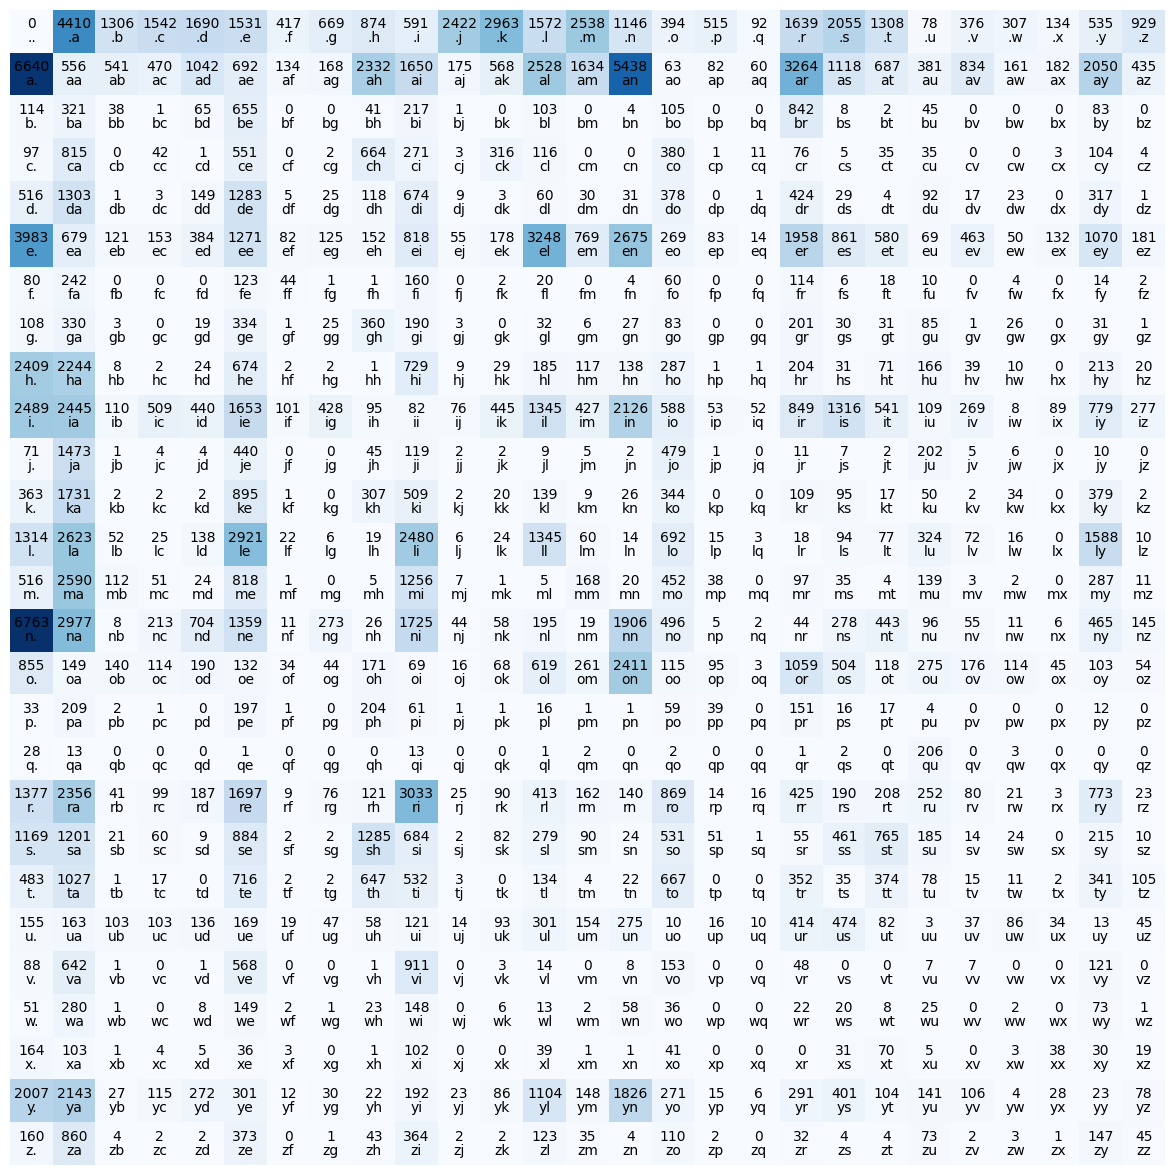

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,15))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, N[i, j].item(), ha = 'center', va= 'bottom')
        plt.text(j, i, chstr, ha = 'center', va = 'top')
plt.axis('off')


In [122]:
p = N[0].float()
p = p / p.sum()


In [158]:
P = (N+1).float()
P = P / P.sum(1, keepdim= True)



In [142]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples = 1, replacement = True, generator=g).item()
ix = 0
out = []
name = ''
for i in range(5):
    ix = 0
    while True:
        # p = N[ix].float()
        # p = p/p.sum()
        # p = torch.ones(27) / 27.0
        
        p = P[ix]
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            out.append(name)
            name = ''
            break
        name += itos[ix]
print('\n'.join(out))


sonde
janasah
p
cony
a


In [160]:
log_likelihood = 0
n = 0

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        
        n += 1
        
print(f'{log_likelihood=}')
negll = -log_likelihood
print(f'{negll=}')
print(f'{negll/n}')
        

log_likelihood=tensor(-14.4636)
negll=tensor(14.4636)
3.6158957481384277


In [325]:
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
xy = torch.tensor(ys)
num = xs.nelement()


In [326]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes = 27).float()
W = torch.rand((27, 27), generator = g, requires_grad=True)

In [339]:


for i in range(100):
    xenc = F.one_hot(xs, num_classes = 27).float()
    logits = xenc@W
    counts = logits.exp()
    probs = counts/counts.sum(1, keepdims = True)
    loss =  -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    W.grad = None
    loss.backward()
    W.data += -50 * W.grad
    print(loss.item())



2.483980655670166
2.4839422702789307
2.4839067459106445
2.483873128890991
2.4838407039642334
2.4838101863861084
2.483781099319458
2.4837522506713867
2.4837253093719482
2.4836983680725098
2.483673095703125
2.4836480617523193
2.483623504638672
2.483599901199341
2.483577251434326
2.4835546016693115
2.483532667160034
2.4835119247436523
2.4834907054901123
2.4834704399108887
2.483450412750244
2.483431339263916
2.483412027359009
2.4833931922912598
2.483375072479248
2.4833569526672363
2.483339309692383
2.4833219051361084
2.483304738998413
2.483288526535034
2.483272075653076
2.4832561016082764
2.4832401275634766
2.483224868774414
2.4832091331481934
2.48319411277771
2.4831795692443848
2.4831645488739014
2.483150005340576
2.4831364154815674
2.4831221103668213
2.4831085205078125
2.4830946922302246
2.483081579208374
2.4830682277679443
2.4830551147460938
2.4830424785614014
2.483030080795288
2.4830172061920166
2.4830048084259033
2.4829928874969482
2.482980728149414
2.482968807220459
2.482956886291504

In [341]:
W[-1].exp()

tensor([ 8.7285, 48.4799,  0.5116,  0.5055,  0.4961, 20.6842,  0.4548,  0.4725,
         2.2942, 20.1742,  0.5076,  0.4388,  6.6946,  1.8563,  0.5216,  5.9822,
         0.4770,  0.4827,  1.7252,  0.5493,  0.5503,  3.9550,  0.5037,  0.5557,
         0.4133,  8.0120,  2.3953], grad_fn=<ExpBackward0>)

In [343]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples = 1, replacement = True, generator=g).item()
ix = 0
out = []
name = ''
for i in range(5):
    ix = 0
    while True:
        # p = N[ix].float()
        # p = p/p.sum()
        # p = torch.ones(27) / 27.0
        xenc = F.one_hot(torch.tensor([ix]), num_classes = 27).float()
        logit = xenc@W
        count = logit.exp()
        p = count / count.sum(1, keepdims=True)
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            out.append(name)
            name = ''
            break
        name += itos[ix]
print('\n'.join(out))

sonde
janasah
prelay
a
nn
